In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cornermatching as cm


I1 = plt.imread('im1.jpg')
I1 = I1.mean(axis=2)

I2 = plt.imread('im2.jpg')
I2 = I2.mean(axis=2)

g_kernal = cm.gauss_kernal(3,2)

I1 = cm.convolve(I1, g_kernal)
I2 = cm.convolve(I2, g_kernal)

In [2]:
import cornermatching as cm
H1 = cm.harris_response(I1)
H2 = cm.harris_response(I2)

In [3]:
import cornermatching as cm
H1sup = cm.nonmaxsup(H1)
H2sup = cm.nonmaxsup(H2)

In [4]:
import cornermatching as cm
H1descrips = cm.descriptorExtractor(I1,H1sup)
H2descrips = cm.descriptorExtractor(I2,H2sup)


In [5]:
import cornermatching as cm
best_matches = cm.get_best_matches(H1descrips, H2descrips)

In [6]:
import cornermatching as cm
secondbest_matches = cm.get_secondbest_matches(H1descrips, H2descrips, best_matches)

[array([311, 304, 312, 121]), array([533, 344, 544, 108]), array([609, 486, 597, 291]), array([329, 246, 329,  57]), array([554, 463, 547, 271]), array([364, 467, 366, 278]), array([366, 467, 366, 278]), array([384, 269, 389,  83]), array([382, 224, 387,  33]), array([327, 482, 331, 292]), array([581, 401, 578, 219]), array([398, 281, 402,  97]), array([678, 334, 682, 152]), array([673, 514, 654, 314]), array([553, 332, 557, 152]), array([456, 223, 466,  33]), array([656, 318, 662, 134]), array([666, 207, 689,  14]), array([671, 206, 693,  14]), array([531, 402, 528, 219]), array([537,  32, 547,  42]), array([448, 473, 444, 279]), array([293, 259, 293,  72]), array([269, 251, 268,  62]), array([319, 219, 319,  26]), array([336, 208, 337,  13]), array([329, 207, 331,  13]), array([283, 474, 289, 284])]


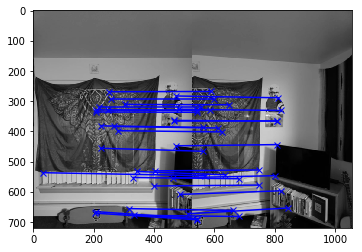

In [7]:
import cornermatching as cm
filtered_matches = cm.filter_matches(best_matches, secondbest_matches)

print(filtered_matches)
h = int(len(I1))
w = int(len(I1[0])*2)
for match in filtered_matches:
    x1 = match[0]
    y1 = match[1]
    x2 = match[2]
    y2 = match[3]
    #print(x1,y1,x2,y2)
    
    plt.plot([y1,y2+int(w/2)], [x1,x2], color="blue", marker="x")
stacked =  np.column_stack((I1, I2)) 
plt.imshow(stacked, cmap=plt.cm.gray)
plt.show()



In [11]:
import random

def RANSAC(number_of_iterations,matches,n,r,d):

    H_best = np.array([[1,0,0],[0,1,0],[0,0,1]])
    list_of_inliers = []
    
    for i in range(number_of_iterations):
  
        # 1. Select a random sample of length n from the matches
        np.random.shuffle(matches)
        samples = np.array(matches[:n])
        
        # 2. Compute a homography based on these points using the methods given above

        H = cm.findHomography(samples)

        # 3. Apply this homography to the remaining points that were not randomly selected

        image1 = []
        image2 = []
        for sample in samples:
            obs = sample[0:2]
            obs = np.append(obs,1)
            image1.append(obs)

            pred = sample[2:]
            pred = np.append(pred,1)
            image2.append(pred)
            
        image1 = np.asarray(image1)

        image1 = (H @ image1.T).T

        # 4. Compute the residual between observed and predicted feature locations
        inliers = []
        for i in range(len(image1)):
            pred = image1[i]
            obs = image2[i]

            #scale
            pred[0]= pred[0]/pred[2]
            pred[1]=pred[1]/pred[2]
            obs[0]= obs[0]/obs[2]
            obs[1]=obs[1]/obs[2]
            
            #readability
            u = pred[0]
            v = pred[1]
            uP = obs[0]
            vP = obs[1]

            #calc residual
            resid = np.sqrt((u-uP)**2+(v-vP)**2)
        # 5. Flag predictions that lie within a predefined distance r from observations as inliers
            if(resid < r):
                inliers.append([u,v,uP,vP])

        # 6. If number of inliers is greater than the previous best
        #    and greater than a minimum number of inliers d,
        #    7. update H_best
        #    8. update list_of_inliers

            if(len(inliers) > len(list_of_inliers) and len(inliers) > d):
                list_of_inliers = inliers.copy()
                H_best = H


    return H_best, list_of_inliers


In [12]:
import cornermatching as cm
matches = filtered_matches.copy()
H_best,inliers = RANSAC(1000,matches,10,3,2)

print(H_best)



[[-4.53849785e-03 -7.98058494e-04  3.06817221e-01]
 [-3.80936615e-05 -4.79790655e-03  9.51738530e-01]
 [-2.27652530e-07 -2.22077822e-06 -3.56484393e-03]]


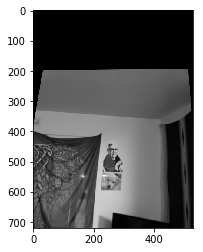

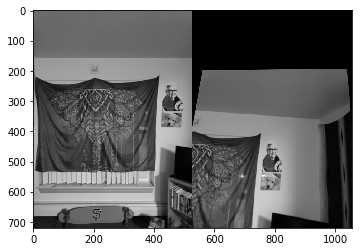

In [13]:
import skimage.transform as skt

proj_trans = skt.ProjectiveTransform(H_best)

image_2_transformed = skt.warp(I2,proj_trans)
plt.imshow(image_2_transformed, cmap=plt.cm.gray)
plt.show()

stitched = np.column_stack((I1,image_2_transformed))

plt.imshow(stitched, cmap=plt.cm.gray)
plt.show()